# Backprojection Tutorial for SAR Image Formation

Basics of Backprojection Algorithm for Processing Synthetic Aperture Radar
Images
Technical Report · February 2016

SAR image formation toolbox for MATLAB
LeRoy A. Gorham and Linda J. Moore
Air Force Research Laboratory, Sensors Directorate
2241 Avionics Circle, Bldg 620, WPAFB, OH 45433-7321

This notebook walks through a minimal, copy‑pasteable implementation of the **filtered backprojection** algorithm using only **NumPy** and **Matplotlib**. You’ll:

1. **Simulate** a point scatterer’s phase history with realistic variation in both frequency and slow‑time.
2. **Visualize** both amplitude and phase of the raw data.
3. **Implement** the backprojection loop with detailed, step‑by‑step comments.
4. **Compare** the reconstructed image against a known ground‑truth map.

---

## 1. Simulating Phase History Data

A single point scatterer at $(x\_0,y\_0,z\_0)$ produces a **phase history**

$$
 s_p(f_k) \;=\; A \,\exp\Bigl(-j\,\tfrac{4\pi f_k}{c}\,R_p\Bigr),
$$

where:

- $A$ = scatterer amplitude
- $f\_k = f\_0 + k,\Delta f$
- $R\_p = \sqrt{(x\_{ant,p}-x\_0)^2 + (y\_{ant,p}-y\_0)^2 + (z\_{ant,p}-z\_0)^2}$
- $c$ = speed of light

In [1]:
import numpy as np
import matplotlib.pyplot as plt

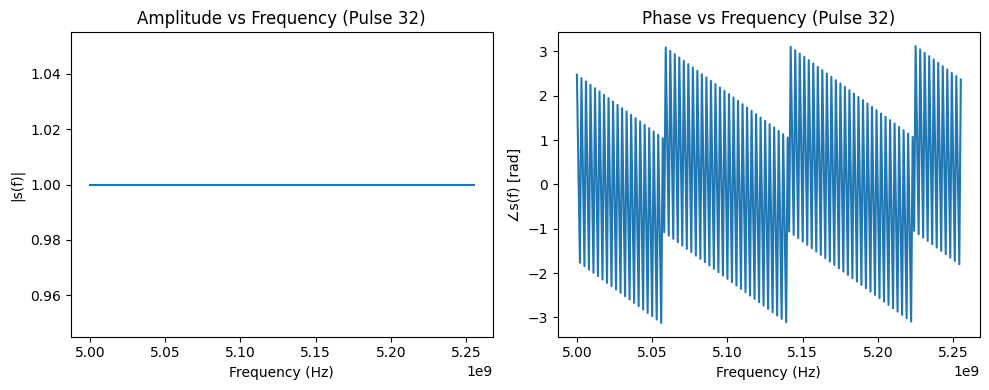

In [4]:
# -- 2D Point Scatterer and Flight Path --
c = 299792458.0       # speed of light [m/s]
f0 = 5e9              # chirp start frequency [Hz]
delta_f = 1e6         # frequency step [Hz]
K = 256               # frequency bins per pulse
Np = 64               # number of pulses

# Scatterer at the origin
a = 1.0               # amplitude
x0, y0, z0 = 0.0, 0.0, 0.0

# Aircraft flies along x from -1000 to +1000 at height h
h = 500.0            # flight altitude [m]
x_ant = np.linspace(-1000, 1000, Np)
y_ant = np.zeros(Np)
z_ant = np.ones(Np) * h

# Allocate phase history: [freq_bin, pulse]
ph_data = np.zeros((K, Np), dtype=complex)
for p in range(Np):
    # Compute slant range for pulse p
    R = np.sqrt((x_ant[p]-x0)**2 + (y_ant[p]-y0)**2 + (z_ant[p]-z0)**2)
    # Frequency axis for this pulse
    freqs = f0 + np.arange(K) * delta_f
    # Complex return
    ph_data[:, p] = a * np.exp(-1j * 4*np.pi*freqs/c * R)

# Plot amplitude and phase for center pulse
pulse = Np//2
freqs = f0 + np.arange(K)*delta_f
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(freqs, np.abs(ph_data[:, pulse]))
ax[0].set(title=f"Amplitude vs Frequency (Pulse {pulse})",
          xlabel="Frequency (Hz)", ylabel="|s(f)|")
ax[1].plot(freqs, np.angle(ph_data[:, pulse]))
ax[1].set(title=f"Phase vs Frequency (Pulse {pulse})",
          xlabel="Frequency (Hz)", ylabel="∠s(f) [rad]")
plt.tight_layout()
plt.show()

## 2. Preparing for Backprojection

We now build an image grid and compute the **range vector** used to interpolate our range‐compressed data.


Doerry §4.3.1, §4.3.2

In [ ]:
# 1) Define image grid in cross‐range (x) and range (y)
Nx, Ny = 200, 200
x_img = np.linspace(-500, 500, Nx)
y_img = np.linspace(-500, 500, Ny)
X, Y = np.meshgrid(x_img, y_img)
Z = np.zeros_like(X)  # assume flat ground

# 2) Backprojection parameters
Nfft = 512  # zero‐padding length for finer range sampling
# Maximum unambiguous range
max_range = c/(2*delta_f)
r_vec = np.linspace(-Nfft/2, Nfft/2-1, Nfft) * (max_range/Nfft)

# 3) Preallocate image
img_bp = np.zeros((Ny, Nx), dtype=complex)

In [8]:
for p in range(Np):
    # ---- 1) Range compression via IFFT ----
    # Convert frequency‐domain data (ph_data[:,p]) into a range profile rc
    rc = np.fft.ifft(ph_data[:, p], n=Nfft)       
    rc = np.fft.fftshift(rc)  # center zero‐range

    # ---- 2) Compute differential range dR ----
    # dR = actual slant range minus reference R0
    R0 = np.sqrt((x_ant[p]-x0)**2 + (y_ant[p]-y0)**2 + (z_ant[p]-z0)**2)
    dR = np.sqrt((x_ant[p] - X)**2 +
                 (y_ant[p] - Y)**2 +
                 (z_ant[p] - Z)**2) - R0

    # ---- 3) Phase correction ----
    # Compensate for phase shift of a point at dR
    ph_corr = np.exp(1j * 4 * np.pi * f0 / c * dR)

    # ---- 4) Interpolation mask ----
    # Only pixels within our precomputed r_vec are valid
    valid = (dR >= r_vec.min()) & (dR <= r_vec.max())

    # ---- 5) Interpolate and accumulate ----
    # Interpolate range‐compressed signal rc at distances dR[valid]
    interpolated = np.interp(dR[valid], r_vec, rc)
    # Multiply by phase correction and sum into final image
    img_bp[valid] += interpolated * ph_corr[valid]

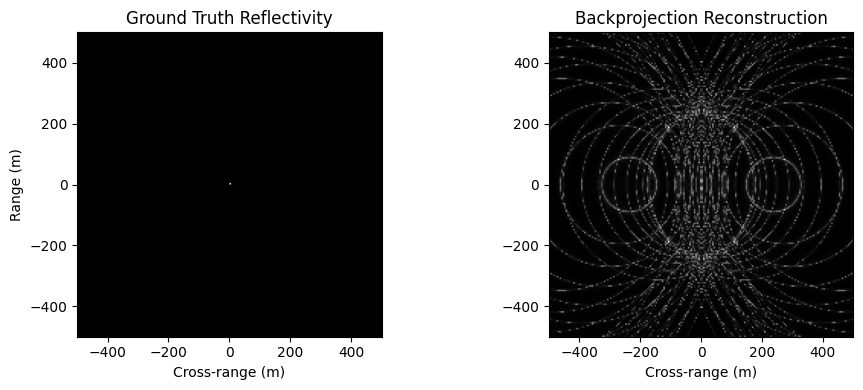

In [10]:
# Real-valued ground-truth map
gt = np.zeros((Ny, Nx), dtype=float)
center = (Ny//2, Nx//2)
gt[center] = 1.0

# Display side-by-side
extent = [x_img[0], x_img[-1], y_img[0], y_img[-1]]
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(gt, cmap='gray', origin='lower', extent=extent)
plt.title('Ground Truth Reflectivity')
plt.xlabel('Cross-range (m)'); plt.ylabel('Range (m)')

plt.subplot(1,2,2)
plt.imshow(np.abs(img_bp), cmap='gray', origin='lower', extent=extent)
plt.title('Backprojection Reconstruction')
plt.xlabel('Cross-range (m)')
plt.tight_layout()
plt.show()


## 5. Next Enhancements

- **Ramp filtering** before range compression to reduce sidelobes (Doerry §4.2.1).
- **RVPE compensation** for platform motion (Doerry §4.2.3).
- **Range-loss correction** to equalize amplitude (Doerry §4.2.4).